In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from scipy.stats import norm, ttest_ind

In [13]:
df_5 = pd.read_pickle('df_5_factors.pkl')
df_20 = pd.read_pickle('df_20_factors.pkl')

In [14]:
df_5.head()

,u_id,i_id,rating,Timestamp,Datetime,Date,pred
0,1,1193,5,978300760,2000-12-31 22:12:40,2000-12-31,2.937616
1,1,661,3,978302109,2000-12-31 22:35:09,2000-12-31,3.251587
2,1,914,3,978301968,2000-12-31 22:32:48,2000-12-31,3.718572
3,1,3408,4,978300275,2000-12-31 22:04:35,2000-12-31,3.288682
4,1,2355,5,978824291,2001-01-06 23:38:11,2001-01-06,2.814991


In [15]:
df_20.head()

,u_id,i_id,rating,Timestamp,Datetime,Date,pred
0,1,1193,5,978300760,2000-12-31 22:12:40,2000-12-31,4.477665
1,1,661,3,978302109,2000-12-31 22:35:09,2000-12-31,3.512411
2,1,914,3,978301968,2000-12-31 22:32:48,2000-12-31,4.196619
3,1,3408,4,978300275,2000-12-31 22:04:35,2000-12-31,3.963851
4,1,2355,5,978824291,2001-01-06 23:38:11,2001-01-06,3.903793


In [16]:
def plot_dist(array1, array2):
    plt.figure(figsize=(12, 6))
    sns.histplot(array1, kde=True, color='blue', label='Group A', stat="density", linewidth=0)
    sns.histplot(array2, kde=True, color='red', label='Group B', stat="density", linewidth=0)
    plt.axvline(np.mean(array1), color='blue', linestyle='dashed', linewidth=2)
    plt.axvline(np.mean(array2), color='red', linestyle='dashed', linewidth=2)
    plt.legend()
    plt.title('Distributions of Ratings for Groups A and B')
    plt.xlabel('Rating')
    plt.ylabel('Density')
    plt.show()

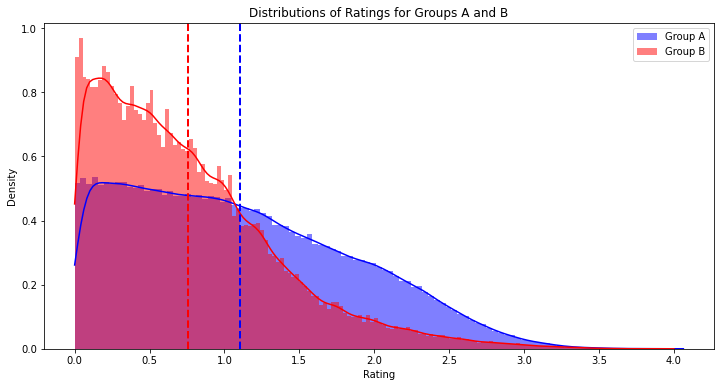

In [17]:
plot_dist(np.abs(df_5['pred'] - df_5['rating']), np.abs(df_20['pred'] - df_20['rating']))

In [19]:
thresh = 0.05

t_stat, p_value = ttest_ind(np.abs(df_5['pred'] - df_5['rating']), np.abs(df_20['pred'] - df_20['rating']), equal_var=False)

In [21]:
if p_value < thresh:
    print("There is a significant difference. Means are not equal")
else:
    print("There is not enough evidence of significant difference")

There is a significant difference. Means are not equal
